Initializing eigensolver data
Computing 5 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 15 x 225 x 300.
Solving for 5 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 15, 0)
     (0, 0, 20)
Cell volume = 300
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.0666667, -0)
     (0, -0, 0.05)
Geometric objects:
     block, center = (0,0,0)
          size (1,1.97826,0.494565)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-0.98913)
          size (0.5,2.71739,1.4837)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,1.6087,-0.98913)
          size (0.5,0.5,1.4837)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-1.6087,-0.98913)
          size (0.5,0.5,1.4837)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-4.73098)
          size (1,10,6)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 5 and 17 object nodes (vs.

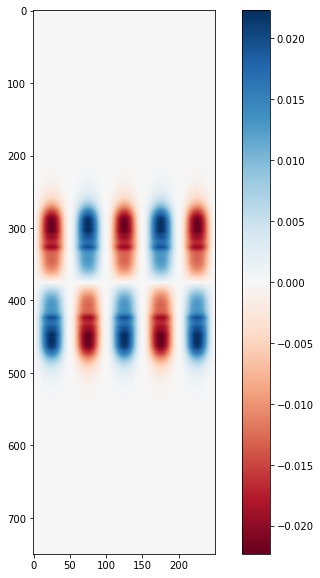

1
real part range: -0.0187335 .. 0.0187335
imag part range: -0.0133417 .. 0.0133417


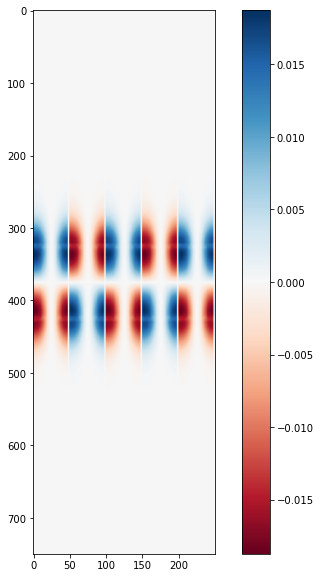

2
real part range: -0.252514 .. 0.252514
imag part range: -0.119373 .. 0.119373


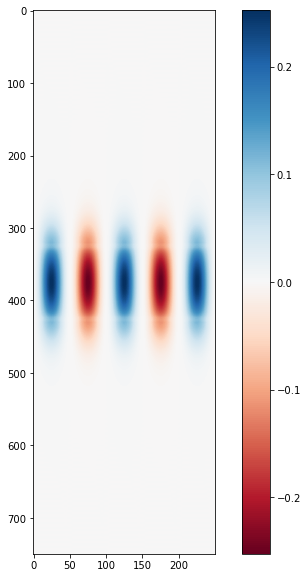

3
real part range: -0.14202 .. 0.14202
imag part range: -0.0668027 .. 0.0668027


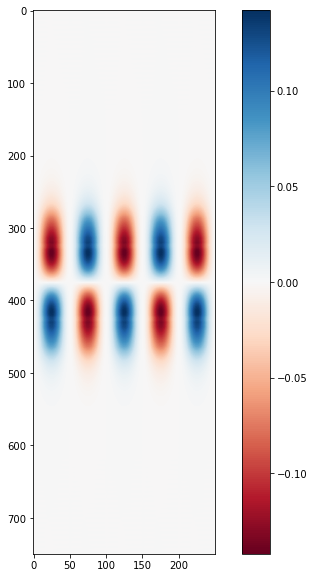

4


In [1]:
####################################################
##### Field Programmable Spin Arrays for Scalable Quantum Repeaters
##### Author: Hanfeng Wang and Kevin C. Chen
##### Date: 12-23-2022
##### 
####################################################

from matplotlib import pyplot as plt
import numpy as np
import math
#import scipy.io

# load the Meep and MPB modules in Python
import meep as mp
from meep import mpb

c =  299792458
NV_omega = (1e-12)*c/(637e-9) # in THz


dx = 0.005
### define device parameters (normalized to a=1)
# note: these numbers can be arbitrary
#a = 0.186

a = 0.184
h = 0.091/a
#h1 = 0.35/a
h2 = 0.273/a
W1 = 0.364/a


air = 1.0
dmd = 2.4
hfo = 1.9
kcl = 1.49

#X = 1
X = 1 #0.2*b
Y = 15
Z = 20#5


X2 = 1/2
#Y1 = 0.2/a/1.1
####################################################
### define alligator geometry verticies (one periodicity)
xs = np.linspace(-X/2,X/2,int(1/dx))



####################################################

outputfields = True
outputepsilon = False
midgapfreq = False
runsim = False
#simtype = "TE"




geometry = [mp.Block(mp.Vector3(X,W1,h), center=mp.Vector3(0,0,0), material=mp.Medium(index=dmd)),
#            mp.Block(mp.Vector3(2*X2,W1,h1), center=mp.Vector3(0,0,h/2+h1/2), material=mp.Medium(index=kcl)),
            mp.Block(mp.Vector3(X2,0.5/a,h2), center=mp.Vector3(0,0,-h/2-h2/2), material=mp.Medium(index=hfo)),
            mp.Block(mp.Vector3(X2,X2,h2), center=mp.Vector3(0,0.25/a+X2/2,-h/2-h2/2), material=mp.Medium(index=1.78)),
            mp.Block(mp.Vector3(X2,X2,h2), center=mp.Vector3(0,-0.25/a-X2/2,-h/2-h2/2), material=mp.Medium(index=1.78)),
            mp.Block(mp.Vector3(X,10,6), center=mp.Vector3(0,0,-3-h/2-h2), material=mp.Medium(index=1.45))]

if midgapfreq:
    midgaps = []
ms = mpb.ModeSolver(                    
                        geometry_lattice=mp.Lattice(size=(X,Y,Z)),
                        geometry=geometry,
                        default_material=mp.Medium(index=air),
                        k_points=mp.interpolate(21, [mp.Vector3(0.3,0,0), mp.Vector3(0.5,0,0)]),
                        resolution=15,
                        # resolution=12,
                        num_bands=5
                        )

if runsim:
    ms.run()
    freqs = ms.all_freqs

    ks = [k.x for k in ms.k_points] # kx wavevector
    plt.figure(figsize=(10,8))
    plt.plot(ks, (1e-12)*(c/(a*1e-6))*freqs, "k-")
    plt.plot([ks[0],ks[-1]],[NV_omega,NV_omega],"k:")
    plt.plot([ks[0],ks[-1]],[ks[0]*c*1e-12/(a*1e-6),ks[-1]*c*1e-12/(a*1e-6)],"k:")
    plt.xlabel("$k_x (2\pi/a)$")
    plt.ylabel("$f$ (THz)")
    plt.title('simtype')
    plt.show()


### Plot mode fields
if outputfields:

    ms.k_points = [mp.Vector3(0.5)]
    ms.run(mpb.fix_efield_phase)
    # ms.run_te_yodd(mpb.fix_efield_phase)
    # ms.run_tm_yeven(mpb.fix_efield_phase)

    md = mpb.MPBData(x=5, resolution=50)
    z0 = int(ms.resolution[0]*Z/2.)
    for i in range(1,5):
        ez1 = np.real(md.convert(ms.get_efield(i,bloch_phase=False)[:,:,z0,2]))
        maxabsz1 = np.max(abs(ez1))
        plt.figure(figsize=(10,10))
        plt.imshow(ez1.T, cmap='RdBu', vmin=-maxabsz1, vmax=+maxabsz1)
        plt.colorbar()
        plt.show()
        print(i)
    
    
### Plot epsilon to check device geometry
if outputepsilon:
    ms.init_params(mp.NO_PARITY,False)
    plt.figure(figsize=(10,10))
    md = mpb.MPBData(x=1, resolution=50)
    A = md.convert(ms.get_epsilon())
    plt.show()


    #eps = ms.get_epsilon()
    #from mayavi import mlab
    #s = mlab.contour3d(eps, colormap="YlGnBu")
    #mlab.show()

In [2]:
np.set_printoptions(threshold=np.inf)
ez1.T

array([[-7.94659539e-07, -1.72644533e-06, -2.65823112e-06,
        -3.59001691e-06, -4.91076858e-06, -6.42600319e-06,
        -7.94123780e-06, -9.21268667e-06, -9.99656406e-06,
        -1.07804414e-05, -1.15643188e-05, -1.15392353e-05,
        -1.15141518e-05, -1.14890683e-05, -9.69208504e-06,
        -7.00915184e-06, -4.32621864e-06, -2.42592750e-06,
        -2.09092046e-06, -1.75591341e-06, -1.42090637e-06,
        -1.34984922e-06, -1.27879206e-06, -1.20773491e-06,
        -9.63309643e-07, -6.32200316e-07, -3.01090989e-07,
         5.71489116e-08,  4.69649958e-07,  8.82151004e-07,
         1.29465205e-06,  1.19141832e-06,  1.08818458e-06,
         9.84950847e-07,  2.56519585e-06,  4.98718021e-06,
         7.40916458e-06,  9.10202150e-06,  9.33662350e-06,
         9.57122551e-06,  9.80582752e-06,  9.07451052e-06,
         8.34319351e-06,  7.61187650e-06,  6.36278810e-06,
         4.85481401e-06,  3.34683991e-06,  2.18683741e-06,
         1.72277812e-06,  1.25871883e-06,  7.94659539e-0

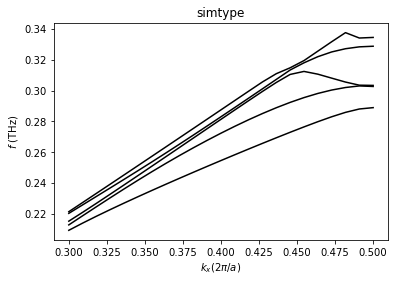

In [4]:
plt.plot(ks, freqs, "k-")
plt.xlabel("$k_x (2\pi/a)$")
plt.ylabel("$f$ (THz)")
plt.title('simtype')
plt.show()


In [5]:
freqs[:,0]

array([0.20935703, 0.21402982, 0.21849968, 0.22281917, 0.2270247 ,
       0.23114044, 0.23518273, 0.23916297, 0.2430893 , 0.24696762,
       0.25080204, 0.25459521, 0.25834833, 0.262061  , 0.26573079,
       0.2693523 , 0.27291544, 0.27640174, 0.27977645, 0.28296993,
       0.28583087, 0.28801701, 0.28889275])

In [6]:
freqs[:,1]

array([0.21286477, 0.21878545, 0.22466162, 0.230476  , 0.23620707,
       0.24183043, 0.2473221 , 0.25266269, 0.25783979, 0.26284683,
       0.26767939, 0.27233152, 0.276793  , 0.28104774, 0.28507248,
       0.28883574, 0.29229655, 0.29540352, 0.29809482, 0.30030014,
       0.30194608, 0.30296581, 0.30262382])

In [7]:
ks

[0.3,
 0.3090909090909091,
 0.3181818181818182,
 0.32727272727272727,
 0.33636363636363636,
 0.34545454545454546,
 0.35454545454545455,
 0.36363636363636365,
 0.37272727272727274,
 0.38181818181818183,
 0.39090909090909093,
 0.4,
 0.40909090909090906,
 0.4181818181818182,
 0.42727272727272725,
 0.4363636363636364,
 0.44545454545454544,
 0.4545454545454546,
 0.4636363636363636,
 0.4727272727272728,
 0.4818181818181818,
 0.49090909090909096,
 0.5]